# Lab2. Custom CNN script with Tensorflow and Keras

In this lab, you will develop your own Tensorflow-based Keras CNN script to recognize characters from cropped license plate.  

## Set up your local environment

* **Plase note that the Tensorflow eager mode will be enabled by below code:**  
 tf.enable_eager_execution()

In [34]:
import numpy as np
from keras import layers

import os
import argparse

import json
from PIL import Image
import tensorflow as tf

#from tensorflow.contrib.eager.python import tfe

tf.enable_eager_execution()

print(tf.VERSION)
import sys
print(sys.version)  

1.15.5
3.6.13 | packaged by conda-forge | (default, Feb 19 2021, 05:36:01) 
[GCC 9.3.0]


* Load the number character definition list 

In [2]:
from constants import JOIN
n_chr = len(JOIN)

## Divide train and valdiation data from cropped images

* We will use cropped-imgs and nums-tags which we generated at Lab0

In [3]:
jsons = os.listdir('gen/nums-tags')
print ('There are {:,} images have annotation files.'.format(len(jsons)))
print ('There are {:,} image files.'.format(len(os.listdir('gen/cropped-imgs'))))

There are 10,000 images have annotation files.
There are 10,000 image files.


* prepare folder to store divided train/validation data

In [4]:
!rm -fR tf
!mkdir tf tf/tf-train tf/tf-train_annotation tf/tf-validation tf/tf-validation_annotation

* Define the number of train/valdiation images

In [5]:
n_samples = len(os.listdir('gen/cropped-imgs'))
n_val = 5000 if n_samples > 25000 else round(n_samples * 0.2)
n_train = n_samples - n_val
print('{:,} images will be used for training, and {:,} images will be used for validation.'.format(n_train, n_val))

8,000 images will be used for training, and 2,000 images will be used for validation.


* Copy images and annotation files to tf-train and tf-validation folders  

In [6]:
import shutil

train_jsons = jsons[:n_train]
val_jsons = jsons[n_train:]

#Moving training files to the training folders
for i in train_jsons:
    image_file = './gen/cropped-imgs/'+i.split('.')[0]+'.png'
    shutil.copy(image_file, './tf/tf-train/')
    shutil.copy('./gen/nums-tags/'+i, './tf/tf-train_annotation/')

#Moving validation files to the validation folders
for i in val_jsons:
    image_file = './gen/cropped-imgs/'+i.split('.')[0]+'.png'
    shutil.copy(image_file, './tf/tf-validation/')
    shutil.copy('./gen/nums-tags/'+i, './tf/tf-validation_annotation/')

* check the move result

In [7]:
print('there are {:,} files in gen/cropped-imgs folder.'.format(len(os.listdir('gen/cropped-imgs'))))
print('there are {:,} files in gen/nums-tags folder.'.format(len(os.listdir('gen/nums-tags'))))
print('there are {:,} files in tf/tf-train folder.'.format(len(os.listdir('tf/tf-train'))))
print('there are {:,} files in tf/tf-train_annotation folder.'.format(len(os.listdir('tf/tf-train_annotation'))))
print('there are {:,} files in tf/tf-validation folder.'.format(len(os.listdir('tf/tf-validation'))))
print('there are {:,} files in tf/tf-validation_annotation folder.'.format(len(os.listdir('tf/tf-validation_annotation'))))

there are 10,000 files in gen/cropped-imgs folder.
there are 10,000 files in gen/nums-tags folder.
there are 8,000 files in tf/tf-train folder.
there are 8,000 files in tf/tf-train_annotation folder.
there are 2,000 files in tf/tf-validation folder.
there are 2,000 files in tf/tf-validation_annotation folder.


## Load data(images/annotations) for local training

* Define a function to read the pair of cropped image and annotation
* Image will be resized to 128 x 64
* Annotation t_annotations and v_annotations are lists of 7 np array representing digit of each 7 positions

In [8]:
def get_data_pair(train_dir, annotation_dir):
    t_jsns = os.listdir(annotation_dir)
    flg_first = True
    for i in t_jsns:
        ext = i.split('.')[1]
        if ext == 'json':
            with open(annotation_dir + '/' + i, "r") as jfile:
                jdata = json.load(jfile)
                # read image
                license_length = 7
                img=Image.open(train_dir + '/' + jdata['file']) 
                img = img.resize((128, 64))
                imgs = img if flg_first else np.append(imgs, img)
                # read license plate numbers
                n_ = np.array(jdata['nums'])
                n_ = np.pad(n_, (0, license_length - len(jdata['nums'])), 'constant', constant_values=(JOIN.index(' ')))
                #print(jfile)
                #print(n_)
                Y_t = np.zeros((n_chr, license_length))
                #print(jdata)
                #print(Y_t)
                #quit()
                Y_t[n_, np.arange(license_length)] = 1
                #print(Y_t)
                Y_ = Y_t if (flg_first) else np.append(Y_, Y_t)
                flg_first = False
    #print(Y_)
    Y_= np.split(Y_.reshape([-1,license_length]), license_length, axis=1)
    return imgs.reshape([-1, 128, 64, 1])/255., [i.reshape([-1,n_chr]) for i in Y_]

In [9]:
t_imgs, t_annotations = get_data_pair('tf/tf-train', 'tf/tf-train_annotation')
v_imgs, v_annotations = get_data_pair('tf/tf-validation', 'tf/tf-validation_annotation')

In [10]:
print('{:,} train images and {:,} annotations were loaded.'.format(len(t_imgs),len(t_annotations[0])))
print('{:,} validation images and {:,} annotations were loaded.'.format(len(v_imgs),len(v_annotations[0])))

8,000 train images and 8,000 annotations were loaded.
2,000 validation images and 2,000 annotations were loaded.


In [27]:
print(len(t_imgs)) # 8,000 examples
print(t_imgs[0].shape)
print(len(t_annotations)) # list of 7 digits
print(t_annotations[0].shape) # each annotation ndarray has the calss of n_chr characters
print(t_annotations[1].shape) 
print(t_annotations[6].shape) 

print(t_annotations[0][0]) 
print(t_annotations[1][0]) 
print(t_annotations[2][0]) 
print(t_annotations[3][0]) 
print(t_annotations[4][0]) 
print(t_annotations[5][0]) 
print(t_annotations[6][0])


8000
(128, 64, 1)
7
(8000, 37)
(8000, 37)
(8000, 37)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


* Check 3 sample pairs of training inage and annotation

In [12]:
import matplotlib.pyplot as plt

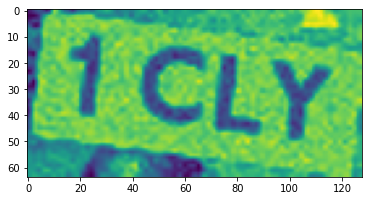

['1', 'C', 'L', 'Y', ' ', ' ', ' ']


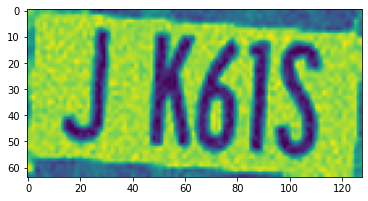

['J', 'K', '6', '1', 'S', ' ', ' ']


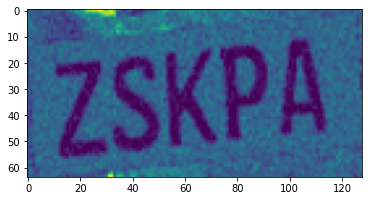

['Z', 'S', 'K', 'P', 'A', ' ', ' ']


In [13]:
for i in range(3):
    plt.imshow(t_imgs[i].reshape([64,128]))
    plt.show()
    digits = [JOIN[np.argmax(t_annotations[0][i])], 
              JOIN[np.argmax(t_annotations[1][i])], 
              JOIN[np.argmax(t_annotations[2][i])], 
              JOIN[np.argmax(t_annotations[3][i])], 
              JOIN[np.argmax(t_annotations[4][i])], 
              JOIN[np.argmax(t_annotations[5][i])], 
              JOIN[np.argmax(t_annotations[6][i])]]
    print(digits)

## Define CNN model
* Define 3 Convolutions layers with Batch Normalization and Max Pooling with Keras
* Will have 7 output nodes representing license plate character at each position

In [14]:
def model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = tf.keras.Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = tf.keras.layers.ZeroPadding2D((2, 2))(X_input)

    # CONV0 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(48, (5, 5), strides = (1, 1), name = 'conv0')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn0')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2), name='max_pool0')(X)

    # CONV1 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(64, (5, 5), strides = (1, 1), name = 'conv1')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn1')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((1, 2), strides = (2, 2), name='max_pool1')(X)

    # CONV2 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(64, (5, 5), strides = (1, 1), name = 'conv2')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn2')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2), name='max_pool2')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = tf.keras.layers.Flatten()(X)
    #----------------------------------------------------------
    d1 = tf.keras.layers.Dense(n_chr, activation='softmax', name='d1')(X)
    d2 = tf.keras.layers.Dense(n_chr, activation='softmax', name='d2')(X)
    d3 = tf.keras.layers.Dense(n_chr, activation='softmax', name='d3')(X)
    d4 = tf.keras.layers.Dense(n_chr, activation='softmax', name='d4')(X)
    d5 = tf.keras.layers.Dense(n_chr, activation='softmax', name='d5')(X)
    d6 = tf.keras.layers.Dense(n_chr, activation='softmax', name='d6')(X)
    d7 = tf.keras.layers.Dense(n_chr, activation='softmax', name='d7')(X)
    
    model = tf.keras.Model(inputs = X_input, 
                  outputs = [d1,d2,d3,d4,d5,d6,d7],
                  name='CNN_ANPR')

    return model

* Compile the model and veiw summary

In [15]:
input_shape = (128,64,1)
model_k = model(input_shape)
model_k.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
                loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy',
                      'categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'],
                metrics = ["accuracy"])
model_k.summary()

Model: "CNN_ANPR"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 64, 1)] 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 132, 68, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 64, 48)  1248        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn0 (BatchNormalization)        (None, 128, 64, 48)  192         conv0[0][0]                      
___________________________________________________________________________________________

* Finally, run traing job
* **It may take 1~2 minutes**
* For now, We wll just run 1 epochs to see if our code works well
* **Do check the loss is decresing and the accuracy is increasing from training job logs**

In [16]:
%%time
model_k.fit(t_imgs, [i.reshape([-1,n_chr]) for i in t_annotations], 
            validation_data=(v_imgs, [i.reshape([-1,n_chr]) for i in v_annotations]), 
            epochs=1, batch_size=128, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 8000 samples, validate on 2000 samples
8000/8000 [==============================] - 533s 67ms/sample - loss: 19.8123 - d1_loss: 3.8987 - d2_loss: 3.9119 - d3_loss: 3.8019 - d4_loss: 3.1571 - d5_loss: 2.4960 - d6_loss: 1.6946 - d7_loss: 0.8370 - d1_acc: 0.0356 - d2_acc: 0.0315 - d3_acc: 0.0956 - d4_acc: 0.2985 - d5_acc: 0.4906 - d6_acc: 0.6944 - d7_acc: 0.8910 - val_loss: 24.4965 - val_d1_loss: 4.0943 - val_d2_loss: 4.0179 - val_d3_loss: 4.3552 - val_d4_loss: 4.6995 - val_d5_loss: 3.9578 - val_d6_loss: 2.3313 - val_d7_loss: 1.0435 - val_d1_acc: 0.0300 - val_d2_acc: 0.0240 - val_d3_acc: 0.1115 - val_d4_acc: 0.2975 - val_d5_acc: 0.4815 - val_d6_acc: 0.7000 - val_d7_acc: 0.8985
CPU times: user 12min 46s, sys: 2min 18s, total: 15min 4s
Wall time: 8min 56s


## Evaluate model (It is not accurate yet)

* Check the overall accuracy

In [17]:
preds = model_k.evaluate(v_imgs, [i.reshape([-1,n_chr]) for i in v_annotations], batch_size=64, verbose=1, sample_weight=None)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

2000/2000 [==============================] - 14s 7ms/sample - loss: 24.4965 - d1_loss: 4.0894 - d2_loss: 4.0187 - d3_loss: 4.3642 - d4_loss: 4.7395 - d5_loss: 3.9847 - d6_loss: 2.3034 - d7_loss: 1.0319 - d1_acc: 0.0300 - d2_acc: 0.0240 - d3_acc: 0.1115 - d4_acc: 0.2975 - d5_acc: 0.4815 - d6_acc: 0.7000 - d7_acc: 0.8985

Loss = 24.496542083740234
Test Accuracy = 4.0893803


* Check the prediction results of 3 sample data pairs

In [18]:
prediction = model_k.predict(v_imgs[:10])

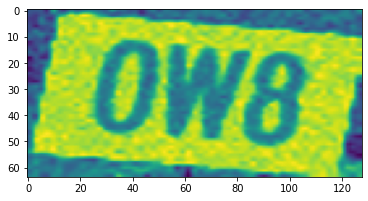

['L', '3', ' ', ' ', ' ', ' ', ' ']


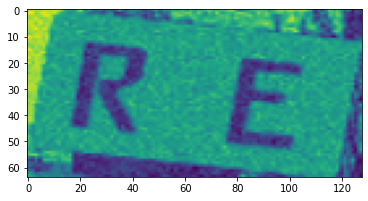

['L', '3', ' ', ' ', ' ', ' ', ' ']


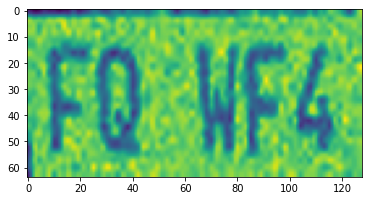

['L', '3', ' ', ' ', ' ', ' ', ' ']


In [19]:
for i in range(3):
    plt.imshow(v_imgs[i].reshape([64,128]))
    plt.show()
    digits = [JOIN[np.argmax(prediction[0][i])], 
              JOIN[np.argmax(prediction[1][i])], 
              JOIN[np.argmax(prediction[2][i])], 
              JOIN[np.argmax(prediction[3][i])], 
              JOIN[np.argmax(prediction[4][i])], 
              JOIN[np.argmax(prediction[5][i])], 
              JOIN[np.argmax(prediction[6][i])]]
    print(digits)

* We verified our code runs successfully
* The accuracy of our model is not good enough yet
* **We will retrain our model with SageMaker in Lab3**

## Next step
Remember you defined model() and get_data_pair() function.  
Move to [Lab3](Lab3-train-deploy-host-on-SM.ipynb) to run this code on the Cloud.